# Imports

In [1]:
import os
import cv2
import time
import shutil
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import gc
import face_detection
import mediapipe as mp

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Bbox of Celeba

In [3]:
def coco_to_pascal_voc(x1, y1, w, h):
    return [x1,y1, x1 + w, y1 + h]

In [4]:
def test_bbox(align_path, wild_path, bbox):
    img = cv2.imread(align_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_wild = cv2.imread(wild_path)
    img_wild = cv2.cvtColor(img_wild, cv2.COLOR_BGR2RGB)

    img_bbox = cv2.rectangle(img.copy(),bbox,(0,255,0),3)
    img_wild_bbox = cv2.rectangle(img_wild.copy(),bbox,(0,255,0),3)

    x_min, y_min, x_max, y_max = coco_to_pascal_voc(bbox[0], bbox[1], bbox[2], bbox[3])

    mask = np.zeros((img.shape[0],img.shape[1]), dtype=np.uint8) # initialize mask
    mask[y_min:y_max,x_min:x_max] = 255 # fill with white pixels

    mask_wild = np.zeros((img_wild.shape[0],img_wild.shape[1]), dtype=np.uint8) # initialize mask
    mask_wild[y_min:y_max,x_min:x_max] = 255 # fill with white pixels

    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,45))
    ax[0].axis('off')
    ax[0].imshow(img)
    ax[0].set_title("Align image")
    ax[1].axis('off')
    ax[1].imshow(img_bbox)
    ax[1].set_title("Align bbox")
    ax[2].axis('off')
    ax[2].imshow(mask)
    ax[2].set_title("Align mask")
    ax[3].axis('off')
    ax[3].imshow(img_wild)
    ax[3].set_title("Wild image")
    ax[4].axis('off')
    ax[4].imshow(img_wild_bbox)
    ax[4].set_title("Wild bbox")
    ax[5].axis('off')
    ax[5].imshow(mask_wild)
    ax[5].set_title("Wild mask")
    plt.show()

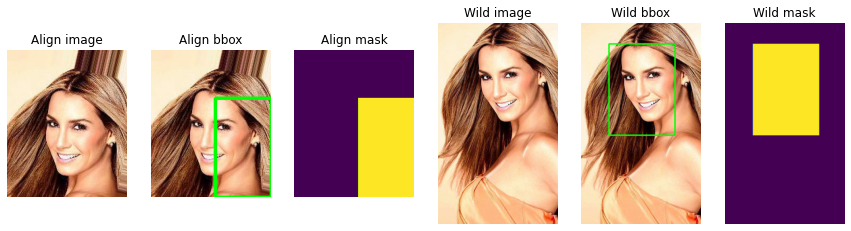

In [5]:
align_path = '/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/img_align_celeba/000001.jpg'
wild_path = '/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/data_wild/img_celeba.7z/img_celeba/000001.jpg'
bbox = 95,71,226,313
test_bbox(align_path, wild_path, bbox)

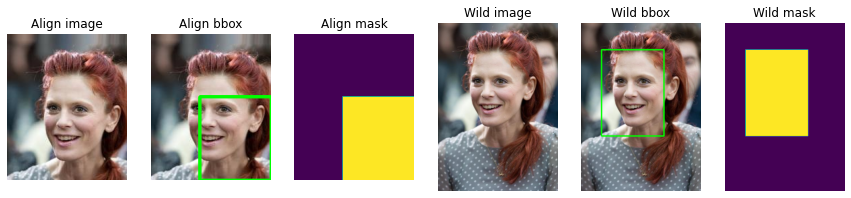

In [6]:
align_path = '/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/img_align_celeba/000002.jpg'
wild_path = '/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/data_wild/img_celeba.7z/img_celeba/000002.jpg'
bbox = 72,94,221,306
test_bbox(align_path, wild_path, bbox)

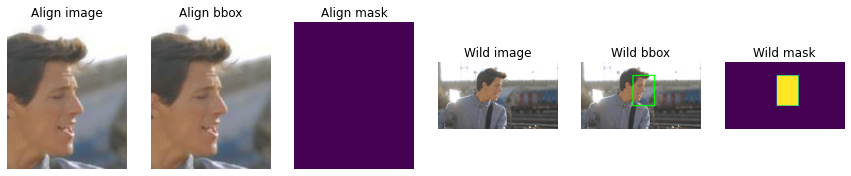

In [7]:
align_path = '/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/img_align_celeba/000003.jpg'
wild_path = '/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/data_wild/img_celeba.7z/img_celeba/000003.jpg'
bbox = 216,59,91,126
test_bbox(align_path, wild_path, bbox)

# Face Detection

In [3]:
align_path = '/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/img_align_celeba/000001.jpg'
img = cv2.imread(align_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Single Shot Multibox Detector (SSD)

In [24]:
def ssd(img):
    detector = cv2.dnn_DetectionModel("res10_300x300_ssd_iter_140000_fp16.caffemodel", "deploy.prototxt")
    start = time.time()
    detections = detector.detect(img)
    totalTime = round(time.time() - start, 3)
    if len(detections[2]) > 0:
        for face in detections[2]:
            cv2.rectangle(img,face,(0,255,0),1)
            gc.collect()
    plt.title("SSD: "+str(totalTime)+"s")
    plt.axis('off')
    plt.grid(False)
    plt.imshow(img)
    return img, totalTime

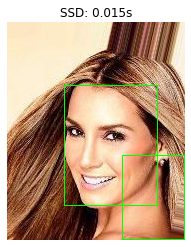

In [25]:
ssd_img, ssd_time = ssd(img.copy())

### Dual Shot Face Detector (DSFD)

In [26]:
def DFSDD(img):
    detector = face_detection.build_detector("DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)
    start = time.time()
    detections = detector.detect(img)
    totalTime = round(time.time() - start, 3)
    if len(detections) > 0:
        for face in detections:
            pred_bbox = face

            pred_bbox[2] = pred_bbox[2] - pred_bbox[0]
            pred_bbox[3] = pred_bbox[3] - pred_bbox[1]

            pred_bbox = [int(i) for i in pred_bbox[:4]]
            cv2.rectangle(img,pred_bbox,(0,255,0),1)
            gc.collect()
    plt.title("DFSDD: "+str(totalTime)+"s")
    plt.grid(False)
    plt.imshow(img)
    return img, totalTime

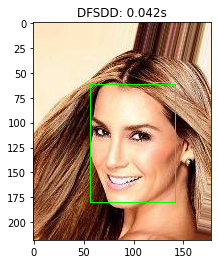

In [27]:
dfsdd_img, dfsdd_time = DFSDD(img.copy())

### RetinaFAce-MobileNetV1

In [28]:
def RNMV(img):
    detector = face_detection.build_detector("RetinaNetMobileNetV1", confidence_threshold=.5, nms_iou_threshold=.3)
    start = time.time()
    detections = detector.detect(img)
    totalTime = round(time.time() - start, 3)
    if len(detections) > 0:
        for face in detections:
            pred_bbox = face
            pred_bbox[2] = pred_bbox[2] - pred_bbox[0]
            pred_bbox[3] = pred_bbox[3] - pred_bbox[1]

            pred_bbox = [int(i) for i in pred_bbox[:4]]
            cv2.rectangle(img,pred_bbox,(0,255,0),1)
            gc.collect()
    plt.title("RNMV: "+str(totalTime)+"s")
    plt.grid(False)
    plt.imshow(img)
    return img, totalTime

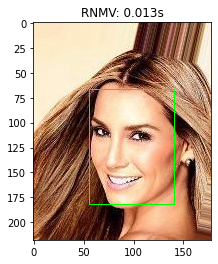

In [29]:
rnmv_img, rnmv_time = RNMV(img.copy())

### RetinaNet-ResNet50

In [30]:
def RNRN50(img):
    detector = face_detection.build_detector("RetinaNetResNet50", confidence_threshold=.5, nms_iou_threshold=.3)
    start = time.time()
    detections = detector.detect(img)
    totalTime = round(time.time() - start, 3)
    if len(detections) > 0:
        for face in detections:
            pred_bbox = face
            pred_bbox[2] = pred_bbox[2] - pred_bbox[0]
            pred_bbox[3] = pred_bbox[3] - pred_bbox[1]

            pred_bbox = [int(i) for i in pred_bbox[:4]]
            cv2.rectangle(img,pred_bbox,(0,255,0),1)
            gc.collect()
    plt.title("RNRN50: "+str(totalTime)+"s")
    plt.grid(False)
    plt.imshow(img)
    return img, totalTime

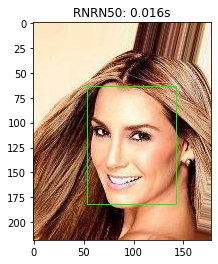

In [31]:
rnrn50_img, rnrn50_time = RNRN50(img.copy())

### MediaPipe

In [32]:
def MP(img):
    mp_face_detection = mp.solutions.face_detection
    detector = mp_face_detection.FaceDetection(min_detection_confidence=0.4)
    start = time.time()
    predictions = detector.process(img)
    totalTime = round(time.time() - start, 3)
    if predictions.detections:
        for detection in predictions.detections:
            img_W = int(img.shape[1])
            img_H = int(img.shape[0])
            pred_bbox = detection.location_data.relative_bounding_box
            pred_bbox = [int(pred_bbox.xmin * img_W), int(pred_bbox.ymin * img_H), int(pred_bbox.width * img_W), int(pred_bbox.height * img_H)]
            cv2.rectangle(img,pred_bbox,(0,255,0),1)

    plt.title("MP: "+str(totalTime)+"s")
    plt.grid(False)
    plt.imshow(img)
    return img, totalTime

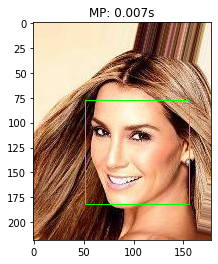

In [33]:
mp_img, mp_time = MP(img.copy())

### Comparison

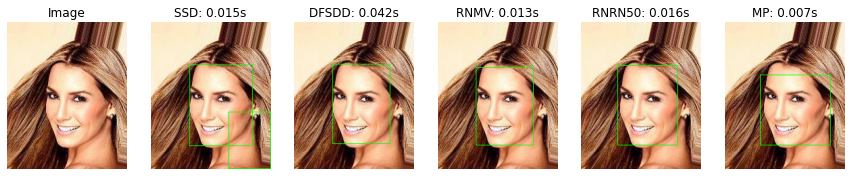

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,45))
ax[0].axis('off')
ax[0].imshow(img)
ax[0].set_title("Image")

ax[1].axis('off')
ax[1].imshow(ssd_img)
ax[1].set_title("SSD: "+str(ssd_time)+"s")

ax[2].axis('off')
ax[2].imshow(dfsdd_img)
ax[2].set_title("DFSDD: "+str(dfsdd_time)+"s")

ax[3].axis('off')
ax[3].imshow(rnmv_img)
ax[3].set_title("RNMV: "+str(rnmv_time)+"s")

ax[4].axis('off')
ax[4].imshow(rnrn50_img)
ax[4].set_title("RNRN50: "+str(rnrn50_time)+"s")

ax[5].axis('off')
ax[5].imshow(mp_img)
ax[5].set_title("MP: "+str(mp_time)+"s")
plt.show()

# Get Bbox, Mask and Create dataset

In [2]:
def RNMV_BBOX_MASK(img):
    detector = face_detection.build_detector("RetinaNetMobileNetV1", confidence_threshold=.5, nms_iou_threshold=.3)
    detection = detector.detect(img)
    pred_bbox = [int(i) for i in detection[0][:4]]
    return pred_bbox

In [3]:
def get_bbox_mask(path_source, path_target, mode):
    files_list = sorted(os.listdir(path_source))
    for curr_file in files_list:
        shutil.copy(os.path.join(path_source, curr_file), os.path.join(f"{path_target}/img", curr_file))
        file_path = os.path.join(path_source, curr_file)
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        bbox = RNMV_BBOX_MASK(img)

        x_min, y_min, x_max, y_max = bbox[0], bbox[1], bbox[2], bbox[3]

        mask = np.zeros((img.shape[0],img.shape[1]), dtype=np.uint8)
        mask[y_min:y_max,x_min:x_max] = 255
        
        ### Clip mask ###
        mask = np.clip(mask, 0, 1)
        kernel = np.ones((1,1), np.uint8)
        dilated_mask = cv2.dilate(mask, kernel)

        cv2.imwrite(f"{path_target}/bbox/{curr_file}", dilated_mask)

        file_id = curr_file.split(".")[0]
        with open(f"{path_target}/bbox/{file_id}.txt", "w+") as f:
            f.write(str(file_id) + ' ' + str(x_min) + ' ' + str(y_min) + ' ' + str(x_max) + ' ' + str(y_max) + '\n')
        f.close()

    with open(f"{path_target}/paths.txt", "w+") as f:
        for curr_file in files_list:
            f.write(str(f"{mode}/img/{curr_file}") + ' ' + str(f"{mode}/bbox/{curr_file}") + '\n')
    f.close()
    print("Doneeeee!")

In [6]:
path_source = "/home/vuong.nguyen/vuong/augmentare/joliGEN/dataset/male_gray_2_female_gray/trainB"
path_target = "/home/vuong.nguyen/vuong/augmentare/joliGEN/dataset/new_diffusion_male_gray_2_female_gray/trainB"
mode = "trainB"

In [7]:
get_bbox_mask(path_source, path_target, mode)

Doneeeee!
